In [1]:
import os
import sys
import xarray as xr
import numpy as np
from numpy import unravel_index
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [4]:
# def process_buoyancy(track):

#     meanlon = data_stats.sel(tracks=track).isel(times=0).meanlon
#     meanlat = data_stats.sel(tracks=track).isel(times=0).meanlat
#     timestamp = str(data_stats.isel(tracks=track,times=0).base_time.values)
#     month = timestamp[5:7]
#     day = timestamp[8:10]
#     hour = timestamp[11:13]

#     tmp = lsmask.sel(longitude=meanlon, latitude=meanlat, method='nearest') # landsea info
#     if tmp == 100: # ocean
#         ls_flag = 0
#     else:
#         ls_flag = 1

#     if ((hour == '00') or (hour == '03') or (hour == '06') or (hour == '09') or
#        (hour == '12') or (hour == '15') or (hour == '18') or (hour == '21')):

#         #print('track: {} date: {}-{}-{}'.format(track,month,day,hour))
#         try:
#             # get buoyancy data
#             data_buoy = xr.open_dataset(buoy_dir / 'era5_2layers_thetae_{}_{}_{}.nc'.format(year,month,day))
#             data_buoy = data_buoy.sel(time=timestamp)
#             # change longitude from 0-360 to -180-180
#             data_buoy.coords['lon'] = (data_buoy.coords['lon'] + 180) % 360 - 180
#             data_buoy = data_buoy.sortby(data_buoy.lon)
#             thetae_bl = data_buoy.thetae_bl
#             thetae_sat_lt = data_buoy.thetae_sat_lt
#             thetae_lt = data_buoy.thetae_lt

#             # calculate buoyancy estimate (K)
#             Buoy_CAPE = ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340
#             Buoy_SUBSAT = ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340

#             Buoy_CAPE_regrid = Buoy_CAPE.interp(lat=lat_regrid, lon=lon_regrid)
#             Buoy_SUBSAT_regrid = Buoy_SUBSAT.interp(lat=lat_regrid, lon=lon_regrid)
            
#             # get the 5-deg mean buoy component around nonMCS center
#             BL_CAPE_mean = Buoy_CAPE_regrid.sel(lat=meanlat,
#                                                 lon=meanlon, method='nearest').values
#             BL_SUBSAT_mean = Buoy_SUBSAT_regrid.sel(lat=meanlat,
#                                                 lon=meanlon, method='nearest').values

#             return (int(ls_flag), float(BL_CAPE_mean), float(BL_SUBSAT_mean))

#         except: # several error files without complete thetae vars.
            
#             return (-999,-999,-999)
            
#     return (-999,-999,-999)

In [5]:
# data_dir = Path('/neelin2020/mcs_flextrkr')
# buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae/')

# # bins for BL_CAPE and BL_SUBSAT
# bins_cape = np.arange(-15,10,0.5)
# bins_subsat = np.arange(-5,25,0.5)
# bins_samples = np.zeros((2,len(bins_cape)-1, len(bins_subsat)-1)) # (cape, subsat) for nonMCS, so no phase

# year = 2014
# # get nonMCS info from previous tracking
# data_stats = xr.open_dataset('/neelin2020/PyFLEXTRKR_OBS/imerge_tropics_2014/stats/trackstats_20140101.0000_20141231.0000.nc')
# # load landsea mask
# tmp = xr.open_dataset('/neelin2020/RGMA_feature_mask/ERA5_LandSeaMask_regrid.nc4').sel(latitude=slice(-40,40))
# lsmask = tmp.landseamask
# lsmask.coords['longitude'] = (lsmask.coords['longitude'] + 180) % 360 - 180
# lsmask = lsmask.sortby(lsmask.longitude)

# lon_regrid = np.arange(-180,180,0.25)
# lat_regrid = np.arange(-30,30+0.25,0.25)

# # assign tracks
# track_list =  data_stats.tracks.values[::500]
# print('total tracks processed: {}'.format(len(track_list)))

# # start multiprocessing
# #pool = Pool(processes=10) # cpu numbes
# results = process_buoyancy(track_list[1])

In [6]:
data_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')

year_list = np.arange(2010,2015)
for n,year in enumerate(year_list):
    
    data = xr.open_dataset(data_dir / 'hist2d_cape_subsat_nonMCS.{}.alltracks.parallel.nc'.format(year))
    if n == 0:
        samples_all = data.samples
    else:
        samples_all = samples_all + data.samples

In [8]:
# climatology of BL,cape, BL,subsat
data= xr.open_dataset('/scratch/wmtsai/temp_mcs/output_stats/era5_BL_3deg_2Dhistogram.wbwl.landsea.2002-2014.nc')
samples_clim_ocean = data.samples.sum(('year','month')).sel(surface_type='ocean')
samples_clim_land = data.samples.sum(('year','month')).sel(surface_type='land')

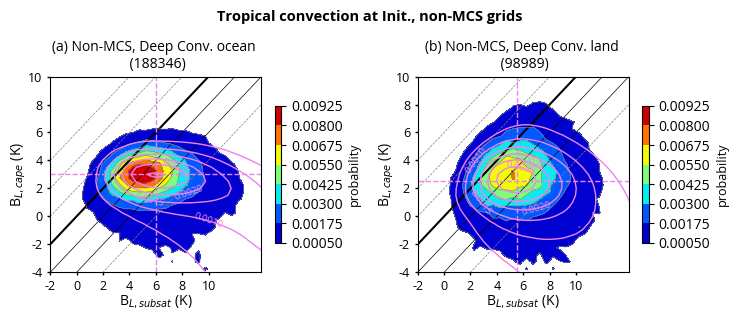

In [92]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(7.5,3))

samples_oce = samples_all.sel(surface_type='ocean').values
samples_lnd = samples_all.sel(surface_type='land').values

for ax,samples,samples_clim,sfc_type,label_str in zip([ax1,ax2,],[samples_oce,  samples_lnd]
                                            , [samples_clim_ocean, samples_clim_land],
                                             ['ocean','land'],['(a)','(b)']):

    samples[samples < 10] = np.nan
    cp = ax.contourf(samples_all.bins_subsat, samples_all.bins_cape, samples/np.nansum(samples)
                       ,levels=np.arange(0.0005,0.01,0.00125), cmap='jet',
                      zorder=2)
    ax.contour(samples_all.bins_subsat, samples_all.bins_cape, samples/np.nansum(samples)
                       ,levels=np.arange(0.0005,0.01,0.00125), colors=['grey'], linewidths=0.5,
                      zorder=3)
    cp.cmap.set_under('w')
    #ax.contour(ds.bins_subsat, ds.bins_cape, samples/np.nansum(samples), colors=['k'], levels=[0.01])
    cbar = plt.colorbar(cp,ax=ax,shrink=0.7, extend='min')
    cbar.set_label('probability',fontsize=9)

    # add buoyancy reference 
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13), color='k', lw=1.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+2, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+4, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)+6, color='grey', ls='--',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-2, color='k', ls='-',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-4, color='k', ls='-',lw=0.5)
    ax.plot(np.linspace(-2,14,13),np.linspace(-2,14,13)-6, color='grey', ls='--',lw=0.5)
    
    ax.set_yticks([-4,-2,0,2,4,6,8,10])
    ax.set_xticks([-4,-2,0,2,4,6,8,10])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_ylim([-4,10])
    ax.set_xlim([-2,14])
    ax.set_xlabel('B$_{L,subsat}$ (K)',fontsize=10, labelpad=0)
    ax.set_xticklabels([-4,-2,0,2,4,6,8,10])
    ax.set_ylabel('B$_{L,cape}$ (K)',fontsize=10, labelpad=0)
    ax.set_yticklabels([-4,-2,0,2,4,6,8,10])
    ax.tick_params(labelsize=9)
    ax.tick_params('both', length=2, width=1, which='major')
    ax.set_title('{} Non-MCS, Deep Conv. {} \n ({})'.format(label_str, sfc_type,int(np.nansum(samples))),
                fontsize=10)
    
    # add climatology joint PDF as reference
    hist2d_clim = (samples_clim/samples_clim.sum())
    hist2d_clim = hist2d_clim.where(hist2d_clim > 0)
    cf = ax.contour(hist2d_clim.BL_subsat_bins, hist2d_clim.BL_cape_bins, hist2d_clim
                    , levels=np.arange(0.0005,0.0035,0.0005), colors=['violet'],linewidths=1, zorder=3)
    ax.clabel(cf, cf.levels, inline=False, fontsize=7)
    # reference lines for the mode of climatology
    (idx,idy) = unravel_index(samples_clim.argmax(), samples_clim.shape)
    ax.vlines(x=samples_all.bins_subsat[idy]-0.25, ymin=-4, ymax=10, color='violet', ls='--', lw=1)
    ax.hlines(y=samples_all.bins_cape[idx]-0.25, xmin=-2, xmax=14, color='violet', ls='--',lw=1)
    
    # set x-y domain 
    ax.set_ylim([-4,10])
    ax.set_xlim([-2,14])
    
plt.tight_layout()
plt.suptitle('Tropical convection at Init., non-MCS grids',fontsize=10.5, fontweight='bold',y=1.05);
plt.show()

fig.savefig('/scratch/wmtsai/temp_mcs/fig/BL2Dhist_nonMCS_ocean_land.png',dpi=300,
          bbox_inches='tight',transparent=False)

#### Where are those high BL,cape grids, which are rarely having convection, located?
- isolated, deep conv. at the mode --> the atmosphere is quite convective unstable at most times
- MCS away from the mode toward lower CAPE, higher subsat --> building blocks of scaling convection
- so why there's no convection occurring over those high CAPE areas (e.g., 4-6K)?

In [ ]:
# %%time

# data_dir = Path('/neelin2020/mcs_flextrkr')
# buoy_dir = Path('/neelin2020/ERA-5_buoy/layer_thetae/')

# year = 2014
# # get nonMCS info from previous tracking 
# data_stats = xr.open_dataset('/neelin2020/PyFLEXTRKR_OBS/imerge_tropics_2014/stats/trackstats_20140101.0000_20141231.0000.nc')
# # load landsea mask
# tmp = xr.open_dataset('/neelin2020/RGMA_feature_mask/ERA5_LandSeaMask_regrid.nc4').sel(latitude=slice(-40,40))
# lsmask = tmp.landseamask    
# lsmask.coords['longitude'] = (lsmask.coords['longitude'] + 180) % 360 - 180
# lsmask = lsmask.sortby(lsmask.longitude)

# lon_regrid = np.arange(-180,180,2.5)
# lat_regrid = np.arange(-30,30+2.5,2.5)
# samples = np.zeros((len(lat_regrid), len(lon_regrid)))

# for track in data_stats.tracks.values[:2000]:
    
#     meanlon = data_stats.sel(tracks=track).isel(times=0).meanlon
#     meanlat = data_stats.sel(tracks=track).isel(times=0).meanlat
#     timestamp = str(data_stats.isel(tracks=track,times=0).base_time.values)
#     month = timestamp[5:7]
#     day = timestamp[8:10]
#     hour = timestamp[11:13]
        
#     if ((hour == '00') or (hour == '03') or (hour == '06') or (hour == '09') or 
#        (hour == '12') or (hour == '15') or (hour == '18') or (hour == '21')):

#         #print('track: {} date: {}-{}-{}'.format(track,month,day,hour))
#         try:
#             # get buoyancy data
#             data_buoy = xr.open_dataset(buoy_dir / 'era5_2layers_thetae_{}_{}_{}.nc'.format(year,month,day))
#             data_buoy = data_buoy.sel(time=timestamp)
#             # change longitude from 0-360 to -180-180
#             data_buoy.coords['lon'] = (data_buoy.coords['lon'] + 180) % 360 - 180
#             data_buoy = data_buoy.sortby(data_buoy.lon)
#             thetae_bl = data_buoy.thetae_bl
#             thetae_sat_lt = data_buoy.thetae_sat_lt
#             thetae_lt = data_buoy.thetae_lt

#             delta_pl=400
#             delta_pb=100
#             wb=(delta_pb/delta_pl)*np.log((delta_pl+delta_pb)/delta_pb)
#             wl=1-wb

#             # calculate buoyancy estimate (K)
#             Buoy_CAPE = ((thetae_bl-thetae_sat_lt)/thetae_sat_lt) * 340 
#             Buoy_SUBSAT = ((thetae_sat_lt-thetae_lt)/thetae_sat_lt) * 340

#             Buoy_CAPE_regrid = Buoy_CAPE.interp(lat=lat_regrid, lon=lon_regrid)
#             Buoy_SUBSAT_regrid = Buoy_SUBSAT.interp(lat=lat_regrid, lon=lon_regrid)

#             # get the 5-deg mean buoy component around nonMCS center
#             BL_CAPE_mean = Buoy_CAPE_regrid.sel(lat=slice(meanlat-2.5,meanlat+2.5),
#                                                 lon=slice(meanlon-2.5,meanlon+2.5)).mean().values
#             BL_SUBSAT_mean = Buoy_SUBSAT_regrid.sel(lat=slice(meanlat-2.5,meanlat+2.5),
#                                                 lon=slice(meanlon-2.5,meanlon+2.5)).mean().values 
            
#             # geolocate those tracks
#             if (BL_CAPE_mean >= 4) and (BL_CAPE_mean <= 6) and (BL_SUBSAT_mean >= 4) and (BL_SUBSAT_mean <= 8):
#                 idx_lon = np.argmin(abs(meanlon.values - lon_regrid))
#                 idx_lat = np.argmin(abs(meanlat.values - lat_regrid))
#                 samples[idx_lat, idx_lon] += 1
                
#         except: 
#             continue

# # writeout 
# out_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')
# ds_geo = xr.Dataset(data_vars=dict(samples=(['lat','lon'], samples)),
#                     coords=dict(lon=(['lon'], lon_regrid),
#                                 lat=(['lat'], lat_regrid)))

In [ ]:
data_dir = Path('/scratch/wmtsai/temp_mcs/output_stats/cape_subsat_hist/')
ds_geo = xr.open_dataset(data_dir / 'geomap_highBLcape_nonMCS.2014.nc')

In [ ]:
# locations for high BL,cape with less convection occurrences

fig, ax = plt.subplots(1,1,figsize=(10,3.5),subplot_kw={'projection': ccrs.PlateCarree()})

ax.coastlines(color='k',linewidth=0.7)
ax.add_feature(cfeat.LAND,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) # maskout LAND
ax.add_feature(cfeat.BORDERS,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3)
ax.add_feature(cfeat.STATES,zorder=3,edgecolor='grey',facecolor='none',linewidth=0.3) 

cp = ax.pcolormesh(ds_geo.lon, ds_geo.lat, ds_geo.samples, cmap='jet', vmin=1, transform=ccrs.PlateCarree())
cp.cmap.set_under('w')
cbar = plt.colorbar(cp, ax=ax, shrink=0.4, extend='min', pad=0.01)
cbar.set_label('nubmer of tracks', fontsize=9)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='k', alpha=0.4, linestyle=':')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.set_title('Higher B$_{L,cape}$ (4-6K), Moderate B$_{L,subsat}$ (4-8K)', fontsize=10)